In [33]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import astropy.io.ascii as aia
import bz2
import glob
import pystan
import re
import seaborn as sns

sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


/Users/farr/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Some $\LaTeX$ macros:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
\newcommand{\Mini}{M_\mathrm{ini}}
\newcommand{\MSun}{M_\odot}
\newcommand{\Myr}{\mathrm{Myr}}
$$

# Re-Analysis of Schneider+ IMF Data

[Schneider, et al. (2018)](https://dx.doi.org/10.1126/science.aan0106) report on an analysis of the stellar parameters of massive stars in 30 Dor that suggests that the high-mass end of the IMF contains more stars than suggested by a Salpeter IMF (i.e. the power-law is shallower than $\diff{N}{M} \propto M^{-2.35}$, more like $\diff{N}{M} \propto M^{-1.9}$).  However, their analysis rests on summing the posteriors of stellar parameters for their sample of observed stars!  Therefore, the distributions they obtain for stellar ages and stellar masses represent the *convolution* of the true distributions for these quantities with observational errors (see, e.g. [Mandel (2010)](https://ui.adsabs.harvard.edu/#abs/2010PhRvD..81h4029M/abstract)); convolving a (broad---See Fig 1 from Schneider, et al. (2018)) observational uncertainty with a steep power law tends to shallow the power law at the high mass end, suggesting that their differences with Salpeter may (at least partly) be a result of their flawed statistical approach.

Schneider, et al. (2018) should be *commended* for providing the data from their stellar parameter fits.  I downloaded the data.  Then I realised they should also be *reprimanded* for not using a truly machine-readable format!  But no matter; by reading the header and manually putting in column names, I can parse it:

In [2]:
stellar_parameters_all = genfromtxt('aan0106_Data_S1.txt', delimiter='\t', comments='#', usecols=(2,3,4,10,11,12,23,24,25,31,32,33), names=('logL', 'dlogLp', 'dlogLm', 'logg', 'dloggp', 'dloggm', 'Mini', 'dMinip', 'dMinim', 'age', 'dagep', 'dagem'))

sel = np.ones(stellar_parameters_all.shape[0], dtype=np.bool)

for n in stellar_parameters_all.dtype.names:
    sel = sel & ~(np.isnan(stellar_parameters_all[n]))

stellar_parameters = stellar_parameters_all[sel]

Here is the data:

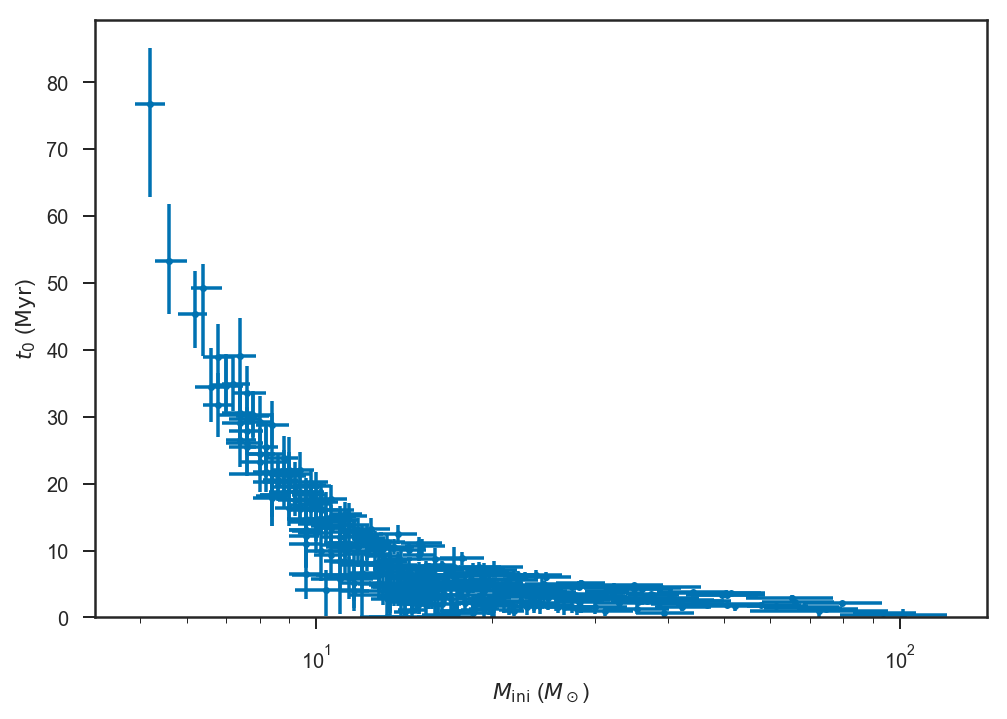

In [3]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.', )
axis(ymin=0)
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
savefig('age-mass-all.pdf')

In [4]:
len(stellar_parameters_all), len(stellar_parameters)

(572, 387)

And restricting to $\Mini \geq 15 \, \MSun$:

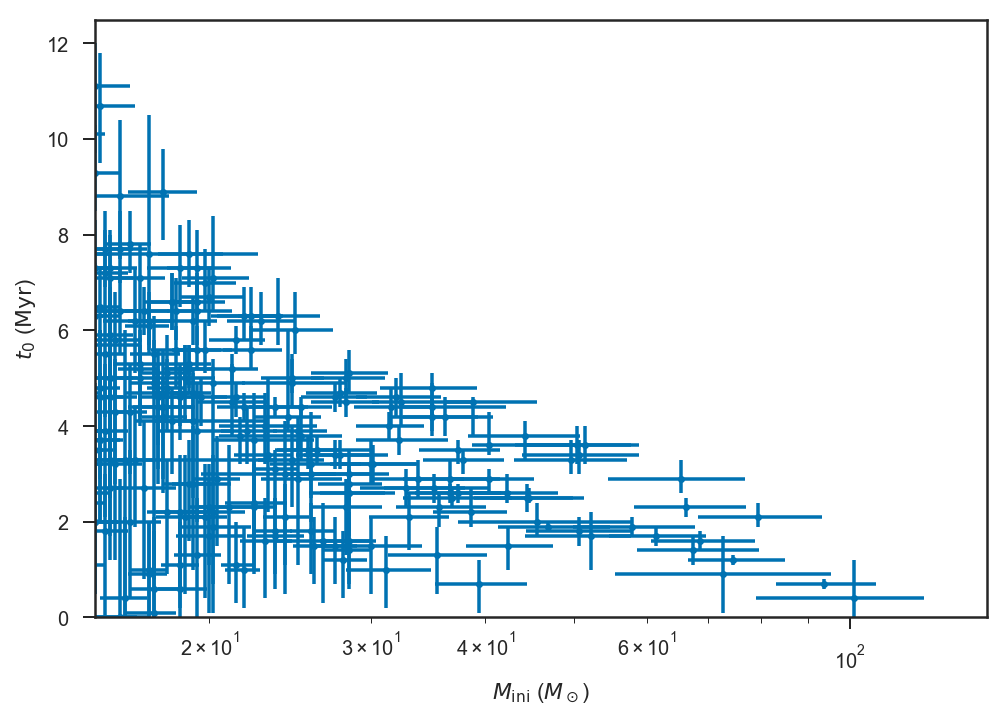

In [5]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.')
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
axis(xmin=15, ymin=0, ymax=12.5)
savefig('age-mass-zoom.pdf')

I grabbed the non-rotating evolutionary models from [Brott, et al. (2011)](https://dx.doi.org/10.1051/0004-6361/201016113) from [VizieR](http://cdsarc.u-strasbg.fr/viz-bin/qcat?J/A+A/530/A115#sRM2.1).  I also grabbed `models.dat`, which gives the masses for the models.

Since 30 Dor has a metallicity around half the solar value, I think it is probably best to use the LMC lifetimes.

In [6]:
masses = []
lifetimes = []
for f in glob.glob('evol/f*.dat'):
    m = float(int(re.match('.*f([0-9]+)-.*', f).group(1)))
    lt = np.max(genfromtxt(f, delimiter='|', usecols=(0,)))
    masses.append(m)
    lifetimes.append(lt)
masses = array(masses)
lifetimes = array(lifetimes)
inds = argsort(masses)
masses = masses[inds]
lifetimes = lifetimes[inds]

The plot below is restricted to $M \geq 15 \, \MSun$.

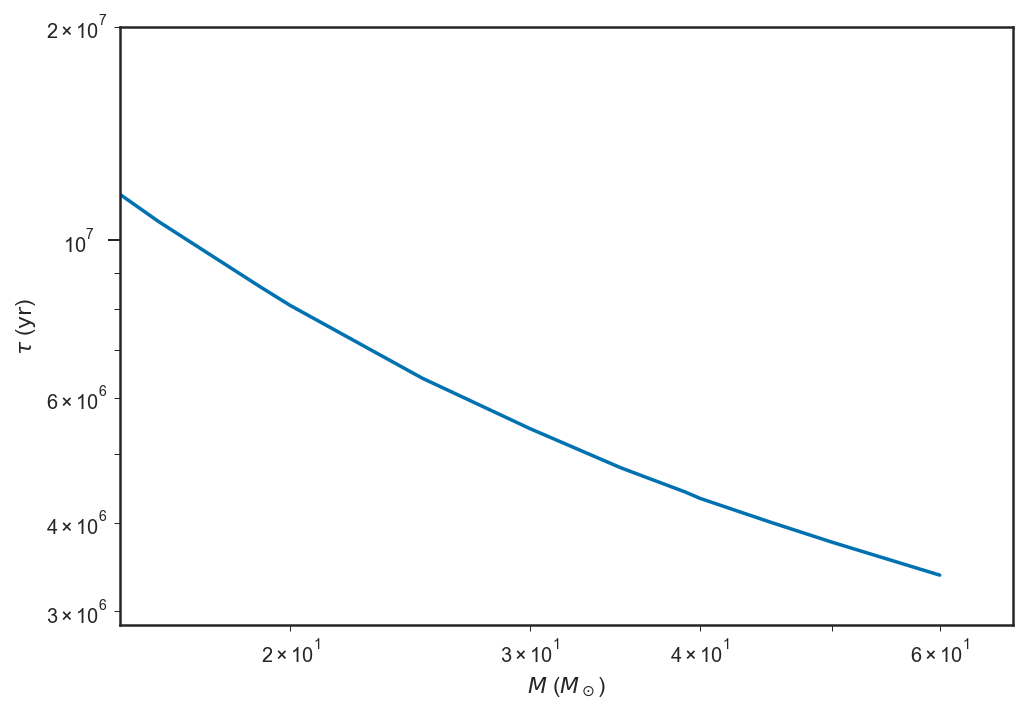

In [7]:
plot(masses, lifetimes)
xscale('log')
yscale('log')
axis(xmin=15, ymax=2e7)
xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

Let's try to interpret this as a power law (it's not, clearly, but maybe it's close).  Hmm, doesn't look too good:

(15, 57.23700725928984, -1.4, -0.50835948614594062)

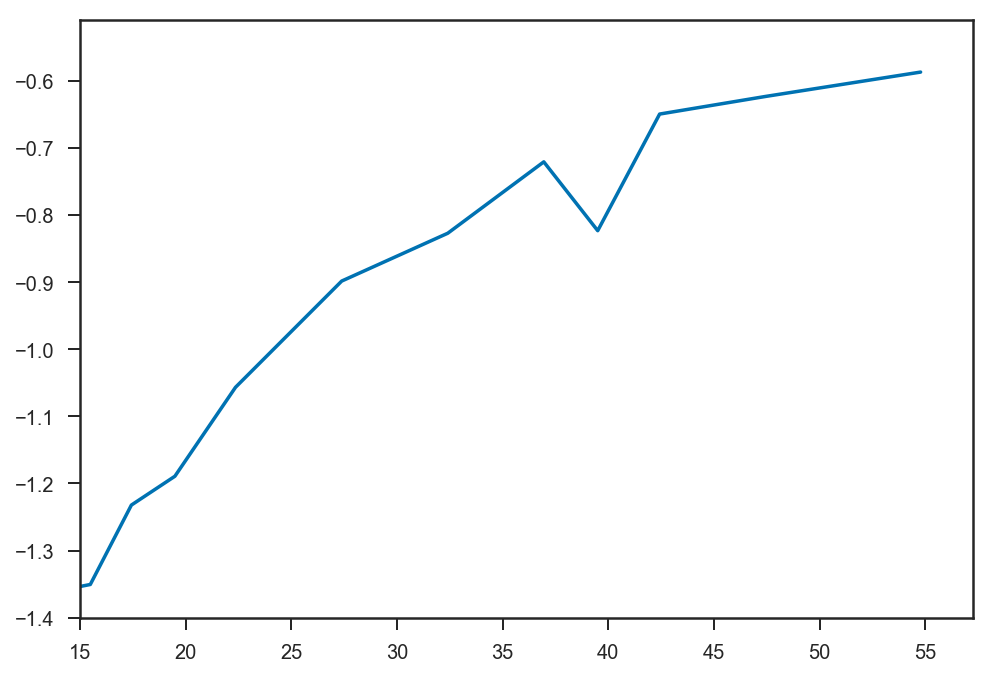

In [8]:
mid_masses = exp(0.5*(log(masses[1:]) + log(masses[:-1])))
plot(mid_masses, diff(log(lifetimes))/diff(log(masses)))
axis(xmin=15, ymin=-1.4)

OK.  How about a log-log fit to polynomials?

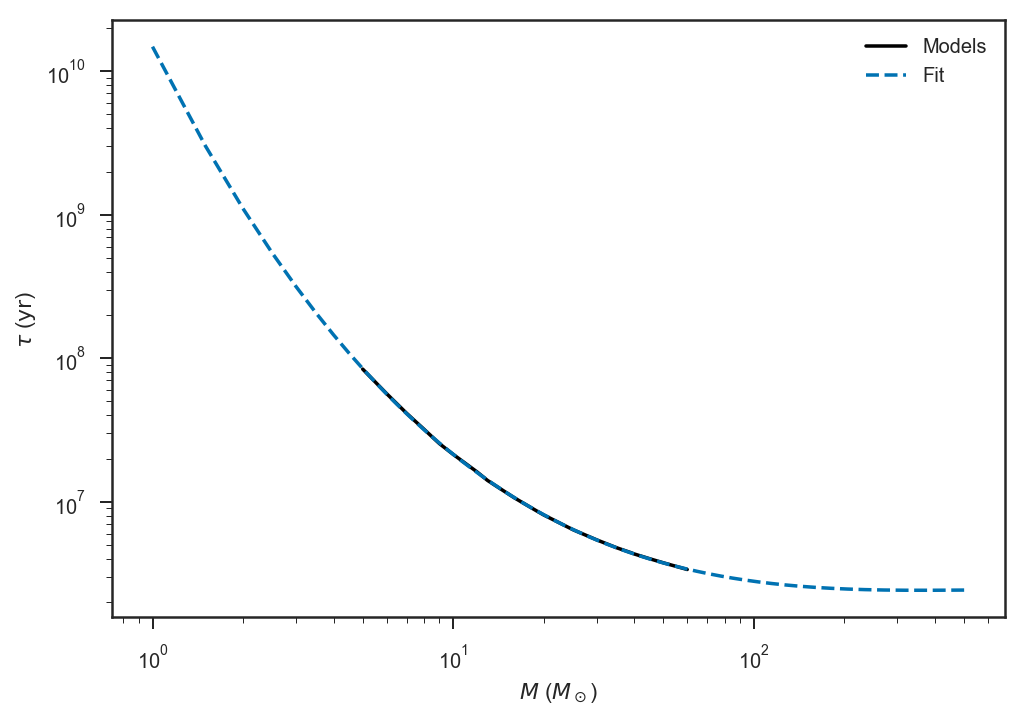

In [9]:
nmasses = masses.shape[0]
M = column_stack((ones(nmasses), log(masses), log(masses)**2, log(masses)**3))
c_lifetime = np.linalg.lstsq(M, log(lifetimes/1e6))[0]
plot(masses, lifetimes, '-k', label='Models')

fit_masses = linspace(1, 500, 1000)
Mfit = column_stack((ones(1000), log(fit_masses), log(fit_masses)**2, log(fit_masses)**3))

plot(fit_masses, exp(np.dot(c_lifetime, Mfit.T))*1e6, '--', label='Fit')
xscale('log')
yscale('log')

legend(loc='best')

xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$\tau$ ($\mathrm{yr}$)')

savefig('lifetime-fit.pdf')

Let's compare against the observed sample:

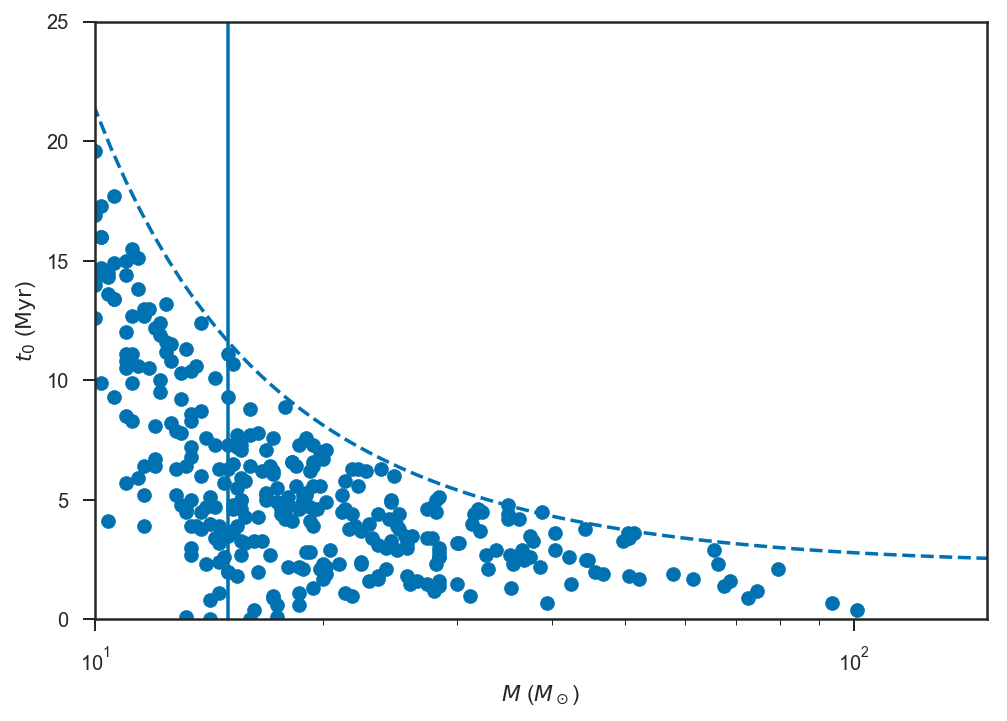

In [10]:
plot(fit_masses, exp(np.dot(c_lifetime, Mfit.T)), '--', label='Fit')
xscale('log')
scatter(stellar_parameters['Mini'], stellar_parameters['age'])

axis(xmin=10, xmax=150, ymax=25, ymin=0)

xlabel(r'$M$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')

axvline(15) # Completeness line.

savefig('lifetime-data.pdf')

It seems reasonable enough that this population ($M \geq 10 \, \MSun$) is subject only to two selection effects: 

* The formation time must be smaller than the main-sequence lifetime ($t_0 \leq \tau(M)$) so the star is still on (or just off, since the giant phase is very short) the main sequence.
* If $M \lesssim 15 \, \MSun$ then the formation time must be sufficiently long ago that the star is bright enough to be observed in the survey:
$$
t_0 \geq \tau_0 \left( 15 \, \MSun - M \right)^\beta
$$
for some constants $\tau_0$ and $\beta > 0$, which we can fit from the data.

We will return to the lower limit on time for smaller masses; for now, let's focus on the supposedly complete sample, with $M > 15 \, \MSun$.

The model is implemented in `IMF.stan`.  Here are a few notes about how the model works.  First, we use a population model that is 
$$
\diff{N}{M \dd t} = \Lambda \frac{\alpha - 1}{M_\mathrm{min}} \left( \frac{M}{M_\mathrm{min}} \right)^{-\alpha} \frac{N\left( t \mid \mu_t, \sigma_t \right)}{\Phi\left( t_\mathrm{max} \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)}
$$
In words: a power-law mass function and a Gaussian SFR, with expected number of stars formed with ages between $0$ and $t_\mathrm{max}$ of $\Lambda$.  Parameters are $\Lambda$, $\alpha$, $\mu_t$, $\sigma_t$.

We assume that the observational likelihood function is a product of normals for mass and age, with 1-sigma intervals matching the quoted 68% credible level.  This is lighter-tailed than some of the likelihoods presented in Schneider, et al. (2018), but easy to implement.  (We can extend it later.)

To implement the selection effects, use direct integration.  We can analytically integrate over the *observable* region in parameter space in age, since the SFR is just a Gaussian (we get a difference of Gaussian CDFs).  Integrating over $M$ is not possible with simple functions, but we can use Stan's ODE computation to solve 
$$
\diff{f_\mathrm{obs}}{M} = \frac{\alpha - 1}{M_\mathrm{min}} \left( \frac{M}{M_\mathrm{min}} \right)^{-\alpha} \frac{\Phi\left( t_+(M) \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)}{\Phi\left(t_\mathrm{max} \mid \mu_t, \sigma_t \right) - \Phi\left( 0 \mid \mu_t, \sigma_t \right)}
$$
where $t_+(M)$ is the maximum lifetime for *observable* systems at mass $M$; $f_\mathrm{obs}(\infty)$ is the fraction of all stars formed that are *observable*, using the initial condition that $f_\mathrm{obs}\left(M_\mathrm{min}\right) = 0$.  The normalising term in the inhomogeneous Poisson distribution is then 
$$
\exp\left[ -\Lambda f_\mathrm{obs}(\infty) \right],
$$
or the expected number of *observed* systems.

To construct the likelihood described above, we produce fictituous $M_\mathrm{obs}$ and uncertainties so the likelihood is normal for $M$ and $t$ with the quoted 68% interval.

In [11]:
mupper = stellar_parameters['Mini'] + stellar_parameters['dMinip']
mlower = stellar_parameters['Mini'] - stellar_parameters['dMinim']

m_obs = 0.5*(mupper + mlower)
sigma_m_obs = 0.5*(mupper - mlower)

tupper = stellar_parameters['age'] + stellar_parameters['dagep']
tlower = stellar_parameters['age'] - stellar_parameters['dagem']

t_obs = 0.5*(tupper + tlower)
sigma_t_obs = 0.5*(tupper - tlower)

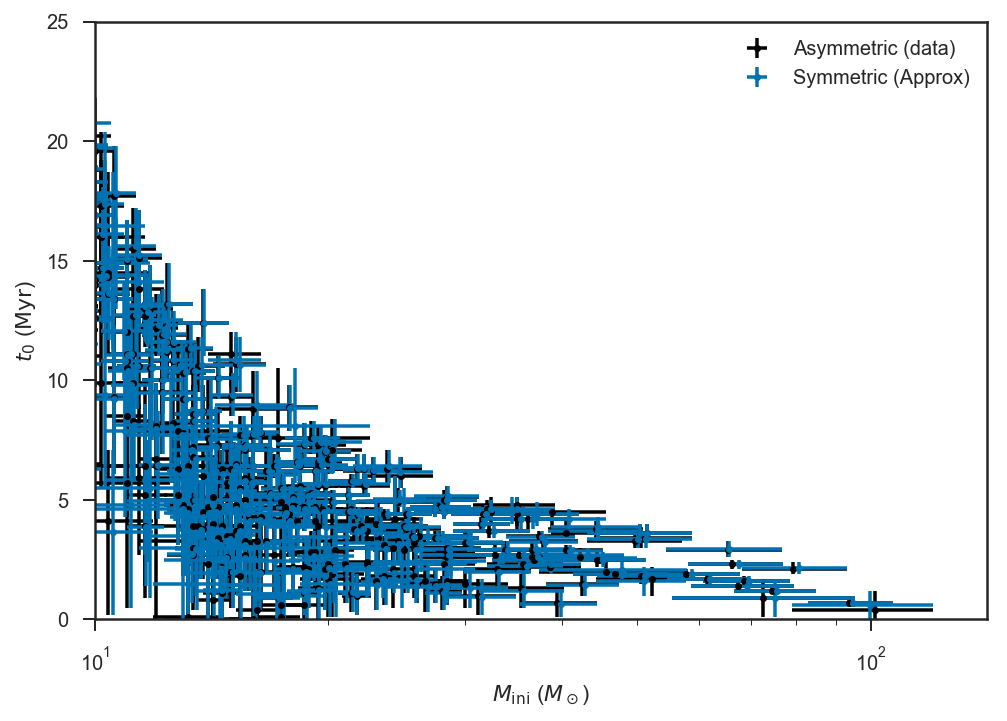

In [12]:
errorbar(stellar_parameters['Mini'], stellar_parameters['age'], yerr=(stellar_parameters['dagem'], stellar_parameters['dagep']), xerr=(stellar_parameters['dMinim'], stellar_parameters['dMinip']), fmt='.', color='k', label="Asymmetric (data)")
errorbar(m_obs, t_obs, yerr=sigma_t_obs, xerr=sigma_m_obs, fmt='.', color=sns.color_palette()[0], label="Symmetric (Approx)")
xscale('log')
xlabel(r'$M_\mathrm{ini}$ ($M_\odot$)')
ylabel(r'$t_0$ ($\mathrm{Myr}$)')
axis(xmin=10, ymin=0, ymax=25)
legend(loc='best')

We select only those systems that have estimated masses above $10 \, \MSun$ (this will introduce some bias, since there are systems with estimated masses below this that have true masses above, and vice versa, but let's return to this point later).  We only consider systems that have formed in the last $25 \, \Myr$.

In [13]:
MMin = 10.0
MComplete = 15.0

tMax = 25.0

sel = stellar_parameters['Mini'] > MComplete

In [14]:
data = {
    'nltc': len(c_lifetime),
    'ltc': c_lifetime,
    
    'MMin': MComplete,
    'tmax': tMax,
    
    'nobs': count_nonzero(sel),
    'Mobs': m_obs[sel],
    'sigma_M': sigma_m_obs[sel],
    'ageobs': t_obs[sel],
    'sigma_age': sigma_t_obs[sel],
}

In [18]:
model = pystan.StanModel(file='IMF.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_55894cf80ecc33e35de771c5cffa8050 NOW.


In [24]:
fit = model.sampling(data=data, iter=2000, thin=1)

In [30]:
fit

Inference for Stan model: anon_model_55894cf80ecc33e35de771c5cffa8050.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
L                    300.0    0.47  29.53 248.65 279.84 297.55 317.71  365.6   4000    1.0
alpha                 2.33  2.7e-3   0.17   2.02   2.22   2.33   2.44   2.67   4000    1.0
mu_t                  4.36  3.5e-3   0.22   3.93   4.22   4.35   4.51    4.8   4000    1.0
sigma_t                2.2  3.5e-3   0.22   1.84   2.04   2.17   2.32    2.7   4000    1.0
Mtrue[0]             58.39    0.18  11.15  36.37  51.13  58.33  65.83  80.62   4000    1.0
Mtrue[1]             18.99    0.02   0.98  17.13  18.33  18.99  19.65  20.94   4000    1.0
Mtrue[2]             25.86    0.05   3.38  19.33  23.62  25.84  28.16  32.47   4000    1.0
Mtrue[3]             91.54    0.19  11.98  67.34  83.57  91.44  99.38 114.83   4000

In [31]:
chain = fit.extract(permuted=True)

In [34]:
with bz2.BZ2File('sampling.pkl.bz2', 'w') as out:
    pickle.dump(model, out)
    pickle.dump(fit, out)
    pickle.dump(chain, out)

/Users/farr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


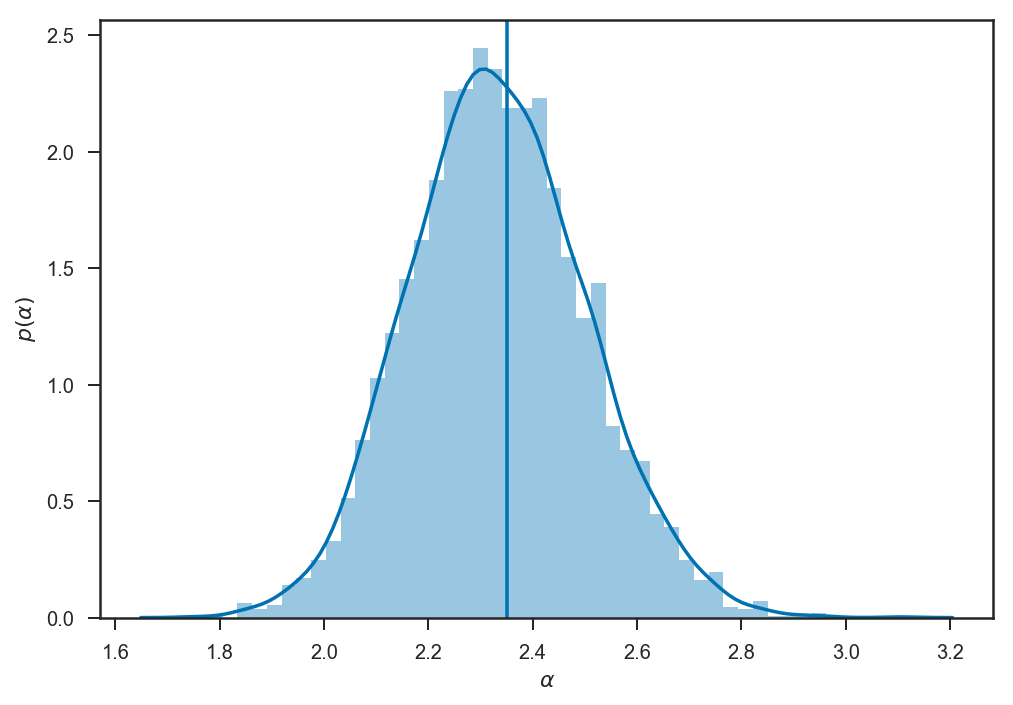

In [35]:
sns.distplot(chain['alpha'])
axvline(2.35)
xlabel(r'$\alpha$')
ylabel(r'$p\left(\alpha\right)$')
savefig('p-alpha.pdf')